# Overall layout of the assignment
Overview: In this assignment you are first going to implement a convolutional graph neural network and then an attention graph neural network by "hand"

Thereafter you are going to implement both using PyTorch Geometric as well as training them on a simple task

# Graph Convoluational Neural Networks

In [ ]:
# Installing relevant modules
#!pip install pytorch_lightning



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install networx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement networx (from versions: none)
ERROR: No matching distribution found for networx


In [ ]:
# Import relevan libraries
import os
import math
import numpy as np

# Flor plotting
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

#torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint



# Graph Convolutions

In [ ]:
# Pytorch module for Graph Convolutions
#TASK_Create a class CGNLayer inhereting class nn.Module (imported from Torch)
#__________#
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):                  # c_in : dimension of input feature, c_out : dimension of output feature
        super().__init__()
        #TASK: Add a linear projection for input features
        self.projection = nn.Linear(c_in, c_out) 

def forward (self, node_feats, adj_matrix):
    '''
    Inputs:
    node_feats = Tensor with node featuers of the shape[batch_size, num_nodes, c_in]
    adj_matrix  = Batch adjecency matrix of the graph - if we are considering self node we will provide 1s on leading Diagonal
    shape:[batch_size, num_nodes, num_nodes]
    '''

    # num_neighbours = number of incoming edges
    num_neighbours = adj_matrix.sum(dim =-1, keepdims =True)    # Find nubmer of neighbours needed for normalization
    # TASK: linear projection of the original node features using "self.projection"
    node_feats_transformed = self.projection(node_feats)
    # TASK: Batchwise matrix multiplication with dimensionality (adj_matrix, node_feats)  - since only nodes with featues have a 1 this results in summing over the linearly projected node featues 
    node_feats_aggregated = torch.bmm(adj_matrix, node_feats_transformed)
    # TASK: Normalization (taking into account the number of adjacent nodes)
    node_feats = node_feats_aggregated / num_neighbours.clamp(min=1)

    return node_feats

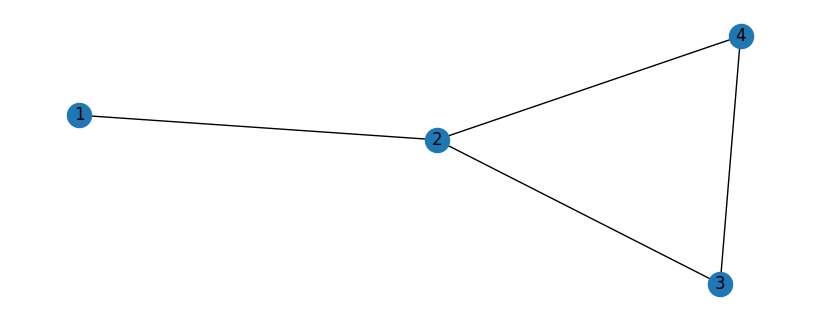

In [ ]:
# Let's apply our Convolutional Graph Layer to an example graph
# Creating and plotting a sample graph

import networkx as nx

# creating a graph
nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])   # creates as touples indicating the connections between two nodes 

import matplotlib.pyplot as plt
#nx.draw(g, with_labels=true)
#Plt.show()

fig = plt.figure(figsize = (8,3))
nx.draw(nx_g, with_labels=True)

In [ ]:
# Defining nodes featues with torch.arrange

node_feats = torch.arange(8, dtype = torch.float32).view(1,4,2)   # creating some featurs

adj_matrix = torch.Tensor([[[1, 1, 0, 0],     # hand based translation of the graph we saw above (could be done using networkx as well)
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])  # leading diagonal always 1, implying that the self node is also a feature 

print("node featues:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)
                                                      

node featues:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [ ]:
# Now let's apply a GCN layer to the graph: for simplicity we inialize the linear weight matrix as identity matrix so that input featues are equal to the message

layer = GCNLayer(c_in=2, c_out=2)   # model

layer.projection.weight.data = torch.Tensor([[1, 0], [0, 1]])
layer.projection.bias.data = torch.Tensor([0, 0])

with torch.no_grad():                       # .no_grad(), since we are doing a simple forward pass
  out_feats = layer(node_feats, adj_matrix) # passingthe features

print("Adjacency matrix", adj_matrix)
print("Input feature", node_feats)
print("Output feaures", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input feature tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output feaures tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


# Graph Attention Neural Network - GAT

In [ ]:
class GATLayer(nn.Module):  # inheriting nn.module
  def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
    super().__init__()

    '''Inputs:
          c_in = dimensionality of input features
          c_out = dimensionality of output features

          num_heads = number of heads in attention mechanism  - if bigger > 1 multihead attention
          concat = if True output of all heads will be concatenated instead of averaging
          alpha = negative slope for leaky ReLu
    '''

    
    self.num_heads = num_heads
    self.concat_heads = concat_heads

    if self.concat_heads:               # if we want to concatenate heads instead of taking the average 
      assert c_out % num_heads == 0;    "number of output featues must be the multiple of the count of heads"
      c_out = c_out // num_heads


    # sub module and parameters needed in the layer
    # TASK: create first linear projection ouput whiche depends on number of heads we want attention for
    self.projection = nn.Linear(c_in, self.c_out_per_head * num_heads)
    # TASK:  Initalize weight one weith matrix per head with dimensionality 2*c_out 
    self.a = nn.Parameter(torch.zeros(size=(2 * self.c_out_per_head, num_heads)))
    # TASK: Intialize leaky relu activation with alpha passed as parameter
    self.leakyrelu = nn.LeakyReLU(alpha)

    #Initialization
    nn.init.xavier_uniform_(self.projection.weight.data, gain = 1.414)   # xavier uniform initialization
    nn.init.xavier_uniform_(self.a.data, gain = 1.414)

  def forward(self, node_feats, adj_matrix, print_attn_probs = False):

    batch_size, num_nodes = node_feats.size(0), node_feats.size(1)     # calculating batch size and number of node featues 

    #apply linear layer
    # TASK: Projecting the node features as for GNNs
    node_feats = self.projection(node_feats)
    node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)   # Convert into batch size, number of nodes and number of heads

    # we need to calculate the attention logits for every edge in the adjacency matrix
    # doing this on all possible nodes will be very expensive
    #TASK: return indices where the adjacency matrix is not zero
    edges = adj_matrix.nonzero(as_tuple=False)

    node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads, -1)    # Flattening out node features

    edge_indices_row = edges[:, 0] #TASK: Pick the edge indices of the row
    edge_indices_col = edges[:, 1] #TASK:  Pick the edge indices of the column
    
    # Concatenating the features of two nodes
    a_input =torch.cat([
        torch.index_select(input = node_feats_flat, index = edge_indices_row, dim =0),
        torch.index_select(input = node_feats_flat, index = edge_indices_col, dim =0)
    ], dim=-1)   #Index select returns a tensor with node_feats_flat being indexed as the desired position along dim =0 

    # Calculate attention MLP output (independen for each head)
  
    attn_logits = torch.einsum('bhc, hc ->bh', a_input, self.a)  # passing our input a_input and weights self.a
    
    attn_logits = self.leakyrelu(attn_logits) #TASK: apply leaky relu to attention logits

    # Map list of attention values back into matrix
    attn_matrix = attn_logits.new_zeros(adj_matrix.shape + (self.num_heads,)).fill_(-9e15)   # creating matrix with zeros
    attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads)==1] = attn_logits.reshape(-1) # Filling with the attention values for relevant indices

    # Weighted average of attention
    attn_probs = F.softmax(attn_matrix, dim=1) # TASK: pass attn_matrix through softmax
  
    if print_attn_probs:
      print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
    node_feats = torch.einsum('bijh, bjhc -> bihc', attn_probs, node_feats)

    # If heads should be concatenated, we cna do this by reshaping. Otherwise, take the mean
    if self.concat_heads:
      node_feats = node_feats.reshape(batch_size,num_nodes, -1)
    else:
      node_feats = node_feats.mean(dim=2)

    return node_feats

In [ ]:
# instantiating the GATNN and doing a forward pass
layer = GATLayer(2,2, num_heads =2, concat_heads=True) 


layer.projection.weight.data = torch.Tensor([[1, 0], [0, 1]])
layer.projection.bias.data = torch.Tensor([0, 0])


layer.a.data = torch.Tensor([[-0.2, 0.3],[0.1,-0.1]])

with torch.no_grad():                       # .no_grad(), since we are doing a simple forward pass
  out_feats = layer(node_feats, adj_matrix, print_attn_probs = False) # passing the features

print("Adjacency matrix", adj_matrix)
print("Input feature", node_feats)
print("Output feaures", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input feature tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output feaures tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


# Using Pytorch Geometric

In [ ]:
#!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=4a2b64a4f7e7bd002223ee86f5e18645d66747acd071de59cfbf3cdf245b5c00
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


In [ ]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data


## Example of node level task: Semi supervised node classification

A popular example that we will use here is the Cora dataset, a citation network among papers. The Cora dataset consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where 1 for a feature indicates that the i-th word of a pre-defined dicationary is present in this article.

In [ ]:
# Load the dataset and normalized features
from torch_geometric.transforms import NormalizeFeatures 
from torch_geometric.datasets import Planetoid # needed to get the dataset
#TASK: Load troch_geometic dataset "Cora" ind save in "Pytorch_Practice_Models", use  NormalizeFeatures() as transform
dataset = Planetoid(root='./Pytorch_Practice_Models', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
data = dataset[0]
data

# 2708 nodes (publications)
# Every node has 1433 features
# edge indexes show what nodes are connected

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# GCN using pytorch-geometric library
from torch_geometric.nn import GCNConv    # Import GCNConv

# TASK: instantiate class GCN as subclass of nn.Module
class GCN(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234)
    # TASK: set up first convolutional GCN layer  with (dataset.num_features, hidden_channels) as dimensionality
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    # TASK: second convoluational GCN layer (maps to the output ), (hidden_channels, dataset.num_classes) as dimensionality
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
     #TASK: conv 1 layer
    x = self.conv1(x, edge_index)
    #TASK: apply relu activation
    x = F.relu(x)
    #TASK: dropout with p=0.5 
    x = F.dropout(x, p=0.5, training=self.training)
    #TASL:  second conv layer
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels  =16)     # Take 16 hidden channels/ hidden features
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
model = GCN(hidden_channels = 16)   #instantiating model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  #TASK: put model in training mode
  model.train()
   #TASK: clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK: Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9458
Epoch: 002, Loss: 1.9401
Epoch: 003, Loss: 1.9330
Epoch: 004, Loss: 1.9251
Epoch: 005, Loss: 1.9166
Epoch: 006, Loss: 1.9053
Epoch: 007, Loss: 1.8923
Epoch: 008, Loss: 1.8807
Epoch: 009, Loss: 1.8683
Epoch: 010, Loss: 1.8520
Epoch: 011, Loss: 1.8423
Epoch: 012, Loss: 1.8265
Epoch: 013, Loss: 1.8180
Epoch: 014, Loss: 1.8017
Epoch: 015, Loss: 1.7859
Epoch: 016, Loss: 1.7723
Epoch: 017, Loss: 1.7508
Epoch: 018, Loss: 1.7455
Epoch: 019, Loss: 1.7208
Epoch: 020, Loss: 1.7019
Epoch: 021, Loss: 1.6856
Epoch: 022, Loss: 1.6666
Epoch: 023, Loss: 1.6437
Epoch: 024, Loss: 1.6198
Epoch: 025, Loss: 1.5929
Epoch: 026, Loss: 1.5827
Epoch: 027, Loss: 1.5722
Epoch: 028, Loss: 1.5474
Epoch: 029, Loss: 1.5115
Epoch: 030, Loss: 1.5251
Epoch: 031, Loss: 1.5039
Epoch: 032, Loss: 1.4766
Epoch: 033, Loss: 1.4585
Epoch: 034, Loss: 1.4162
Epoch: 035, Loss: 1.3889
Epoch: 036, Loss: 1.3767
Epoch: 037, Loss: 1.4026
Epoch: 038, Loss: 1.3401
Epoch: 039, Loss: 1.3186
Epoch: 040, Loss: 1.3123


In [ ]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8090


In [ ]:
# Geaph Attention Neural Network

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads):
    super().__init__()
    torch.manual_seed(1234)
    # TASK: first convolutional GAT layer      (takes the input)
    self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
    # TASK: second convoluational GAT layer (maps to the output )
    self.conv2 = GATConv(hidden_channels * heads, data.num_classes, heads=heads, concat=False)

  def forward(self, x, edge_index):
    #TASK: dropout p=0.6 use dropout
    x = F.dropout(x, p=0.6, training=self.training)
    #TASK: GAT 1 layer
    x = self.conv1(x, edge_index)
    #TAKS: apply elu activation
    x = F.elu(x)
    #TASK: use dropout, p=0.6
    x = F.dropout(x, p=0.6, training=self.training)
    #TASK apply second GAT layer
    x = self.conv2(x, edge_index)
    return x

model = GAT(hidden_channels  =8, heads=1)     # Take 8 hidden channels/ hidden features and 8 heads
print(model)



GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)


In [ ]:
model = GAT(hidden_channels  =8, heads=8)  #instantiating model
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  # TASK: set model in training mode 
  model.train()
  # TASK:  clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

 
for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9470
Epoch: 002, Loss: 1.9454
Epoch: 003, Loss: 1.9410
Epoch: 004, Loss: 1.9390
Epoch: 005, Loss: 1.9363
Epoch: 006, Loss: 1.9354
Epoch: 007, Loss: 1.9314
Epoch: 008, Loss: 1.9277
Epoch: 009, Loss: 1.9217
Epoch: 010, Loss: 1.9203
Epoch: 011, Loss: 1.9191
Epoch: 012, Loss: 1.9118
Epoch: 013, Loss: 1.9127
Epoch: 014, Loss: 1.9096
Epoch: 015, Loss: 1.9054
Epoch: 016, Loss: 1.8987
Epoch: 017, Loss: 1.8968
Epoch: 018, Loss: 1.8967
Epoch: 019, Loss: 1.8895
Epoch: 020, Loss: 1.8953
Epoch: 021, Loss: 1.8852
Epoch: 022, Loss: 1.8754
Epoch: 023, Loss: 1.8742
Epoch: 024, Loss: 1.8685
Epoch: 025, Loss: 1.8665
Epoch: 026, Loss: 1.8629
Epoch: 027, Loss: 1.8610
Epoch: 028, Loss: 1.8550
Epoch: 029, Loss: 1.8520
Epoch: 030, Loss: 1.8455
Epoch: 031, Loss: 1.8405
Epoch: 032, Loss: 1.8382
Epoch: 033, Loss: 1.8294
Epoch: 034, Loss: 1.8314
Epoch: 035, Loss: 1.8133
Epoch: 036, Loss: 1.8187
Epoch: 037, Loss: 1.8158
Epoch: 038, Loss: 1.8046
Epoch: 039, Loss: 1.7988
Epoch: 040, Loss: 1.8008


In [ ]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7650


Summary: in this context and the particular set-up graph convolutions are more effective than graph attention. Propose (argue for), implement and evaluate two potential improvements for the graph attention neural network

In the scenario where graph convolutions are found more effective than graph attention mechanisms, it could be due to several reasons such as the architecture’s inability to leverage the flexibility provided by attention mechanisms effectively, or perhaps due to the problem domain and data characteristics that favor convolutions for feature aggregation over attention mechanisms. Here are two proposed improvements to enhance the performance of a Graph Attention Network (GAT):

### 1. **Multi-Head Attention with Diverse Initialization**
**Proposition**: The effectiveness of the attention mechanism can be greatly enhanced by using multi-head attention, where each head learns a different aspect of the data. Diverse initialization of each attention head might encourage exploration of different representational spaces, potentially capturing a wider range of node feature relationships.

**Implementation Suggestion**:
- Increase the number of heads in the GAT layer while ensuring that each head starts with a unique initial state. This could be achieved by varying the initialization parameters across heads.
- Consider using orthogonal or sparse initialization techniques which might encourage each head to develop different and potentially complementary representations of the input features.

**Evaluation Approach**:
- Test the network's performance with varying numbers of attention heads and types of initializations.
- Compare the results against a baseline model to see if there's an improvement in performance metrics like accuracy on a validation set or a specific task-related metric.

### 2. **Incorporate Edge Features in Attention Mechanisms**
**Proposition**: Standard GATs do not explicitly incorporate edge features, which can provide crucial contextual information about the relationship between nodes. Modifying the GAT to account for edge features could enhance its ability to model inter-node relationships and improve performance.

**Implementation Suggestion**:
- Modify the attention mechanism to include edge features in the computation of attention coefficients. This can be done by extending the attention mechanism's input to include edge attributes, which influence the computation of attention scores between nodes.
- The attention function could be redefined as \( e_{ij} = a(\mathbf{W}[h_i \| h_j \| e_{ij}]) \), where \( e_{ij} \) are the edge features between nodes \( i \) and \( j \), and \( a \) is a learnable function (e.g., a neural network).

**Evaluation Approach**:
- Evaluate the model on datasets where edge features are known to be informative (e.g., molecular graphs where edge types represent different bond types).
- Compare performance metrics (like classification accuracy or regression error) against a version of the model that does not use edge features.

### General Evaluation Setup
For both improvements, a rigorous evaluation would involve:
- Training the modified GAT models on a standard dataset where baseline performance is established.
- Using k-fold cross-validation or a held-out test set to assess performance.
- Analyzing the results using metrics such as accuracy, F1 score, or ROC-AUC for classification tasks. For regression or other types of tasks, appropriate metrics like RMSE or MAE should be used.
- Optionally, visualize attention scores or learned embeddings to qualitatively assess how the model is interpreting the graph structure.

These improvements aim to leverage the flexibility and capacity of GATs more effectively, potentially overcoming scenarios where traditional GCN architectures perform better.